In [319]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
torch.__version__

'2.4.1+cu121'

## The essence of machine learning and deep learning is to take some data from the past, build an algorithm (like a neural network) to discover patterns in it and use the discovered patterns to predict the future.

# 1. Data preparing and loading

In [320]:
# As we don't have any data right now, we are going to create some 
# Create *known* parameters ( taken from a previous model)
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1) # X is making data and we add a dimension so now our data become a 2dimentional
y = weight * X + bias
print(X[:10])
print(y[:10])
print(X.shape)
print(X.ndim)
print(y.shape)
print(y.ndim)



tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280],
        [0.3350],
        [0.3420],
        [0.3490],
        [0.3560],
        [0.3630]])
torch.Size([100, 1])
2
torch.Size([100, 1])
2


## Here generally X = Features and y = labels. 
## Split data into training and test sets

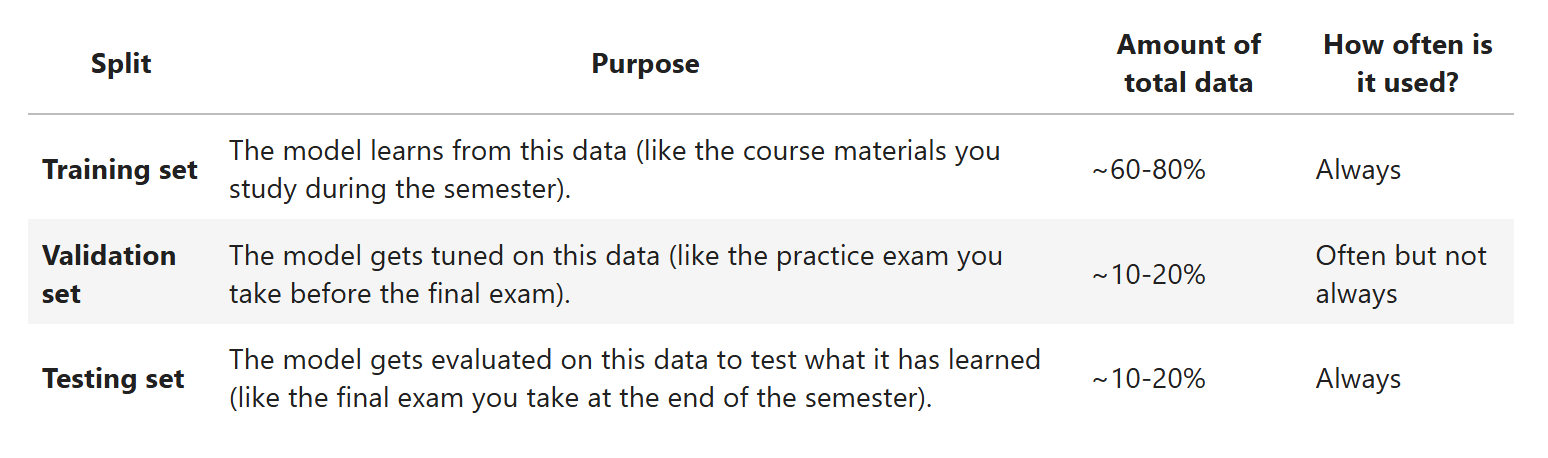

In [321]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [322]:
# Let's create a function to visualize it.
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(8, 6))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="g", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="black", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});



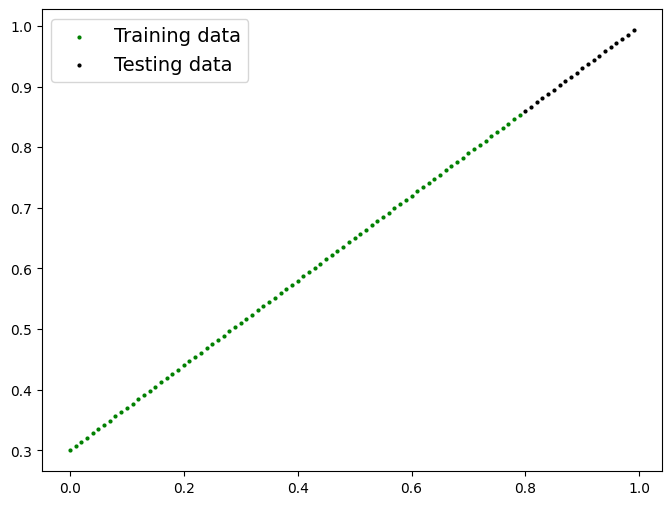

In [323]:
plot_predictions()

# 2. Build Model

### Now we have got some data, lets build a model to use the green dots to predict the black dots

In [324]:
# Create a Linear Regression Model class
class LinearRegressionModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float),
                                    requires_grad=True)
        
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float),
                                 requires_grad=True)
    
    # Forward defines the computation in the model
    def forward(self, x:torch.Tensor)->torch.Tensor: # "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # y = mx + b

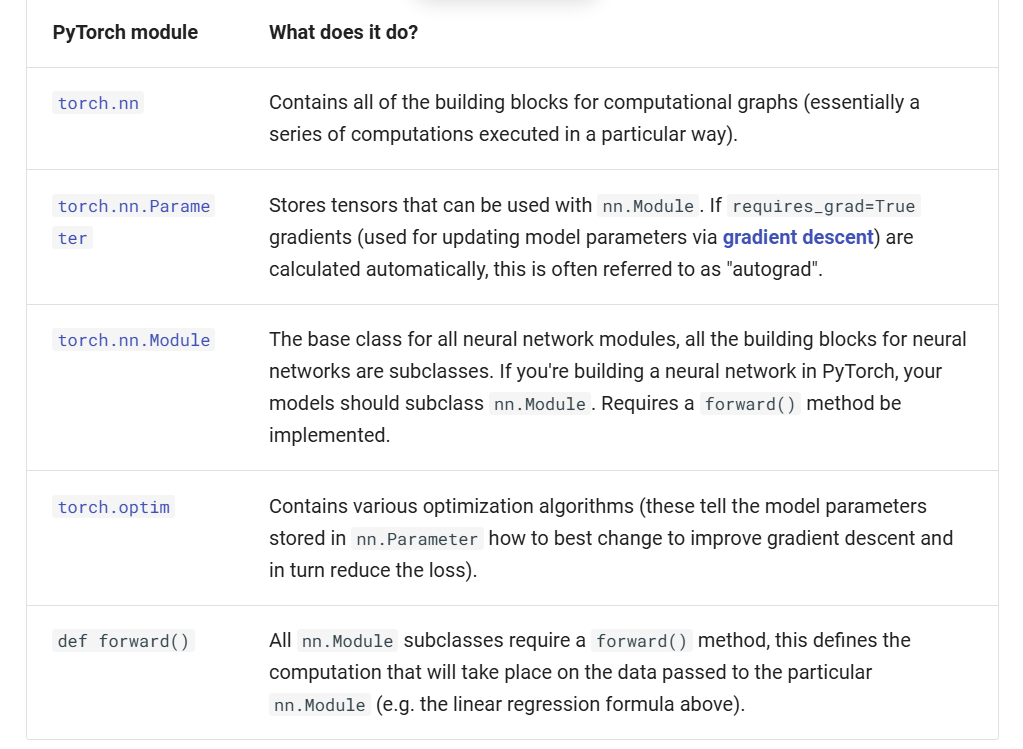

In [325]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameters)
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [326]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using torch.inference_mode()
#### When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we've defined.

In [327]:
# Make predictions with our Model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [328]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")


Number of testing samples: 20
Number of predictions made: 20
Predicted values:
tensor([[0.3982],
        [0.4015],
        [0.4049],
        [0.4083],
        [0.4116],
        [0.4150],
        [0.4184],
        [0.4217],
        [0.4251],
        [0.4285],
        [0.4318],
        [0.4352],
        [0.4386],
        [0.4419],
        [0.4453],
        [0.4487],
        [0.4520],
        [0.4554],
        [0.4588],
        [0.4621]])


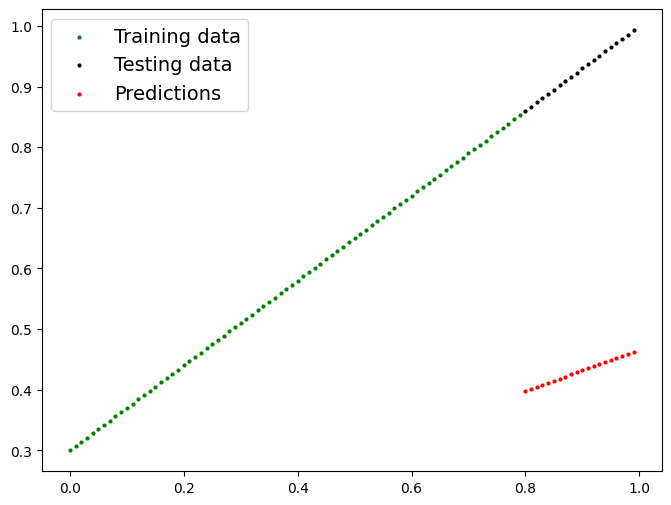

In [329]:
# Make visualize prediction as well
plot_predictions(predictions=y_preds)

In [330]:
y_test - y_preds

tensor([[0.4618],
        [0.4655],
        [0.4691],
        [0.4727],
        [0.4764],
        [0.4800],
        [0.4836],
        [0.4873],
        [0.4909],
        [0.4945],
        [0.4982],
        [0.5018],
        [0.5054],
        [0.5091],
        [0.5127],
        [0.5163],
        [0.5200],
        [0.5236],
        [0.5272],
        [0.5309]])

# 3. Train Model


## Creating a loss function and optimizer in PyTorch

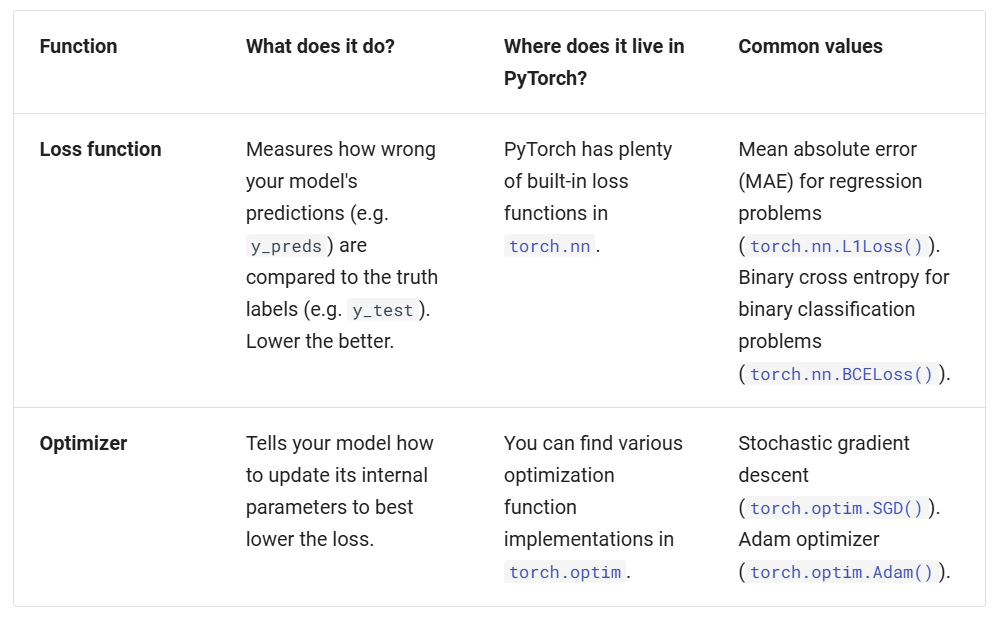

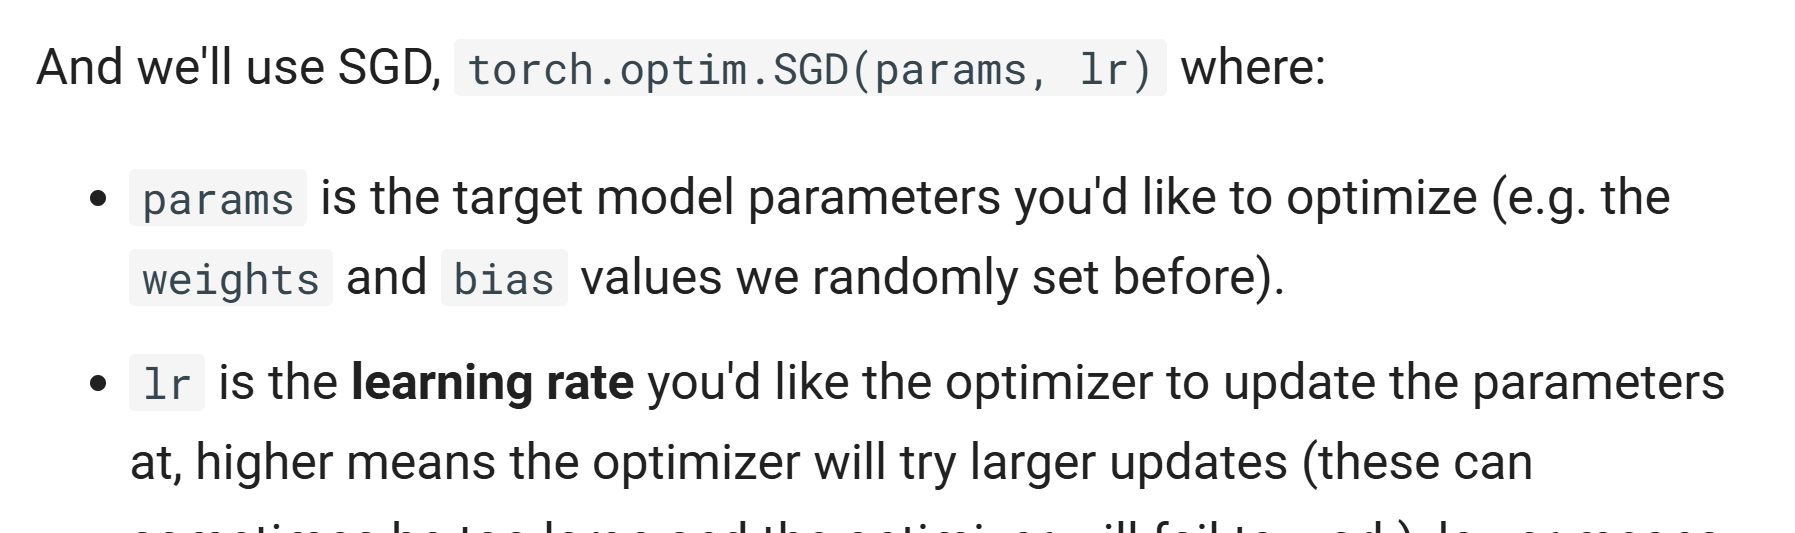

In [331]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE -> Mean Absolute Error

# Create teh optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

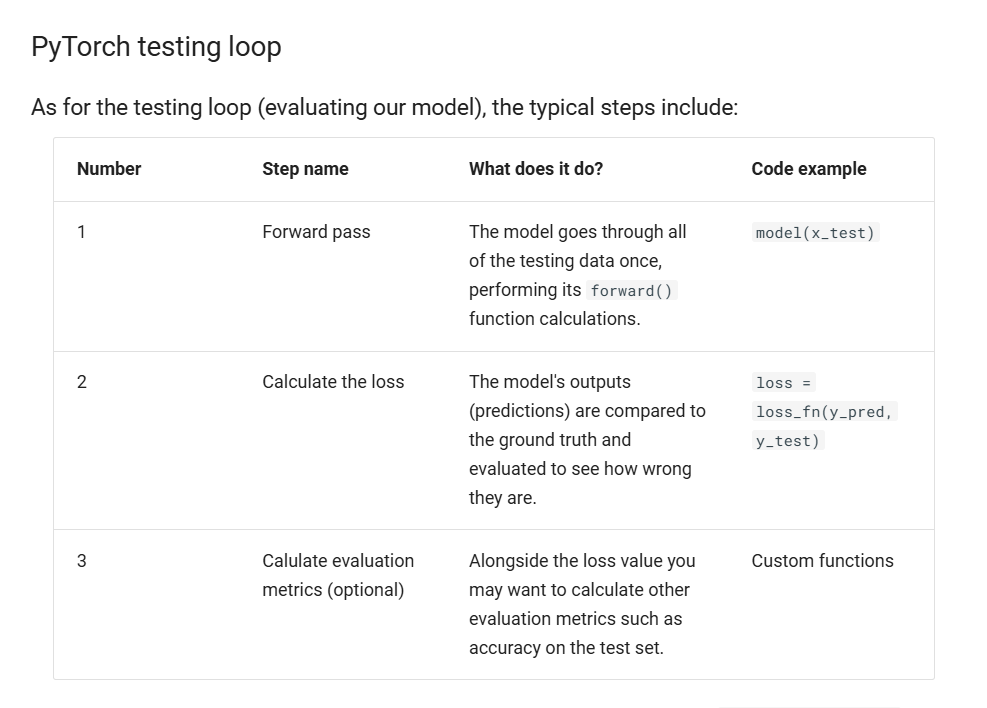

## Let's train our model for 100 epochs


In [332]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31469792127609253 | MAE Test Loss: 0.48281747102737427 
Epoch: 10 | MAE Train Loss: 0.19909533858299255 | MAE Test Loss: 0.3474648892879486 
Epoch: 20 | MAE Train Loss: 0.08958515524864197 | MAE Test Loss: 0.21752354502677917 
Epoch: 30 | MAE Train Loss: 0.05288771912455559 | MAE Test Loss: 0.1439102590084076 
Epoch: 40 | MAE Train Loss: 0.045192889869213104 | MAE Test Loss: 0.11271438747644424 
Epoch: 50 | MAE Train Loss: 0.04140976816415787 | MAE Test Loss: 0.09821617603302002 
Epoch: 60 | MAE Train Loss: 0.03795855492353439 | MAE Test Loss: 0.0888485461473465 
Epoch: 70 | MAE Train Loss: 0.034532517194747925 | MAE Test Loss: 0.08085694909095764 
Epoch: 80 | MAE Train Loss: 0.03110707364976406 | MAE Test Loss: 0.07252134382724762 
Epoch: 90 | MAE Train Loss: 0.027681414037942886 | MAE Test Loss: 0.06452975422143936 
Epoch: 100 | MAE Train Loss: 0.02425537072122097 | MAE Test Loss: 0.05653815343976021 
Epoch: 110 | MAE Train Loss: 0.02082989364862442 | MAE

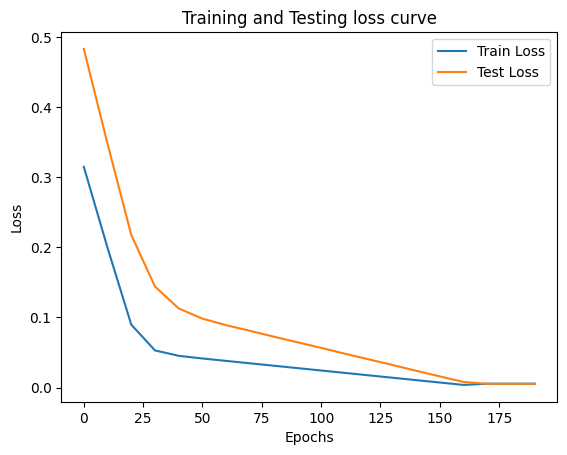

In [333]:
# lets plot the loss curve
plt.plot(epoch_count, train_loss_values, label='Train Loss')
plt.plot(epoch_count, test_loss_values, label='Test Loss')
plt.title("Training and Testing loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [334]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6944])), ('bias', tensor([0.2968]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# 4. Making predictions with a trained PyTorch model (inference)

In [335]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
total_sample = len(y_preds)
print(total_sample)
print(y_preds)


20
tensor([[0.8523],
        [0.8592],
        [0.8662],
        [0.8731],
        [0.8801],
        [0.8870],
        [0.8940],
        [0.9009],
        [0.9078],
        [0.9148],
        [0.9217],
        [0.9287],
        [0.9356],
        [0.9426],
        [0.9495],
        [0.9564],
        [0.9634],
        [0.9703],
        [0.9773],
        [0.9842]])


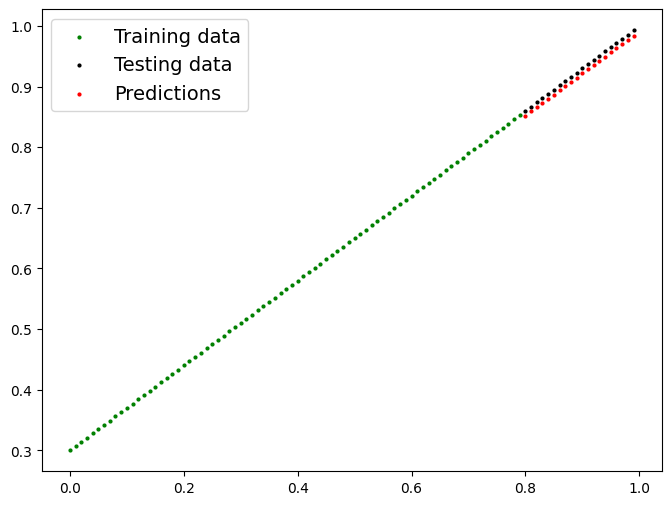

In [336]:
plot_predictions(predictions=y_preds)

# 5. Saving and loading a PyTorch model

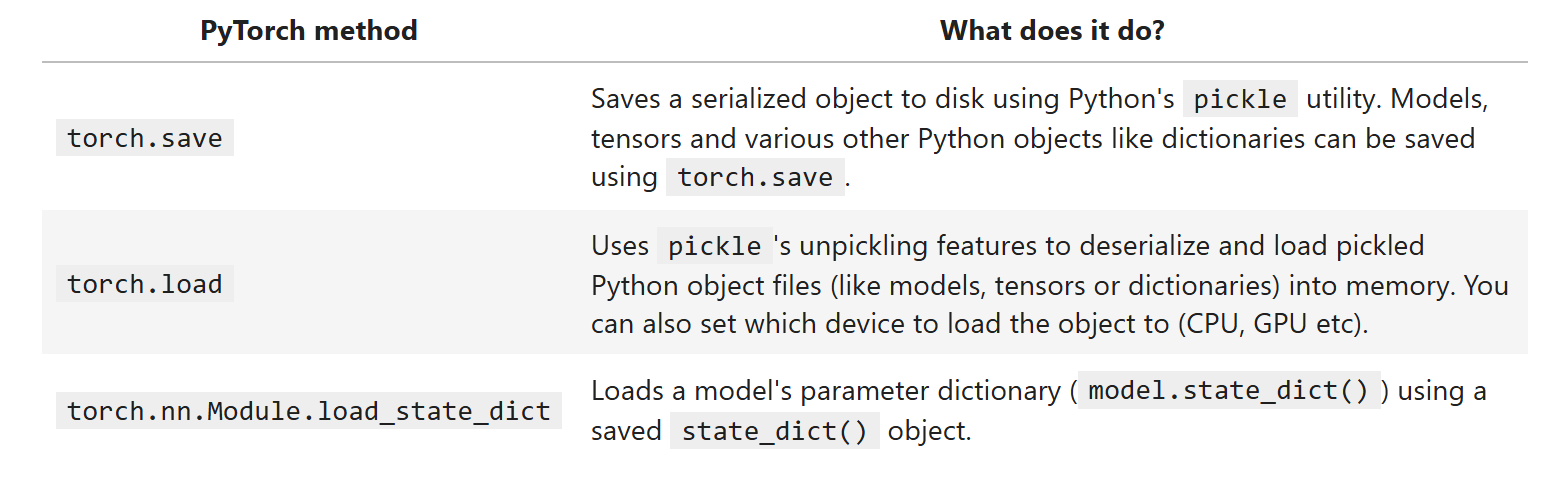

### Saving a PyTorch model's state_dict()

In [337]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models_20")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = 'module_02_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the odel state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models_20/module_02_workflow_model_0.pth


In [338]:
# Check the saved file path
!ls -l models_20/module_02_workflow_model_0.pth

-rw-rw-r-- 1 xia_1818 xia_1818 1674 11月 21 11:24 models_20/module_02_workflow_model_0.pth


## Loading a saved PyTorch model's state_dict()

In [339]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

/tmp/ipykernel_1321890/1296048670.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [340]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    

In [341]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Now we will practise it again but it will be in the GPU 


In [342]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.1+cu121'

In [343]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# 1. DATA

In [344]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.01

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

# 2. Split the DATA

In [345]:
train_split = int(len(X) * 0.8)

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

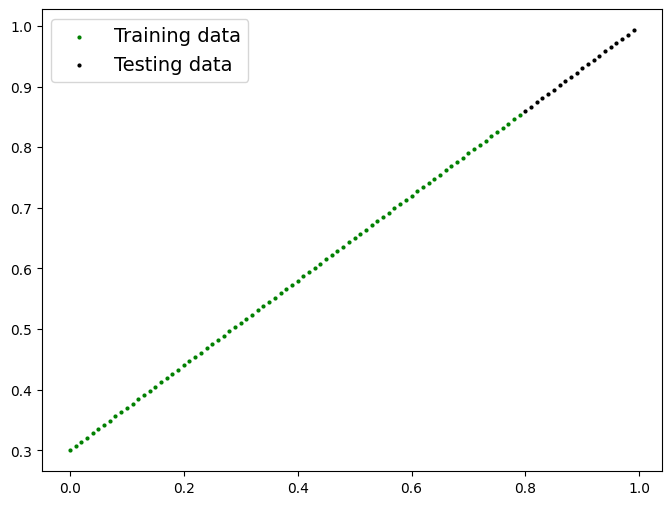

In [346]:
 # you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

# 3. Building a pytorch Linear Model


In [347]:
# Subclass nn.Module to make our mdoel
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [348]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [349]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

# 4. Training

In [350]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [351]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5555006265640259 | Test loss: 0.574234664440155


Epoch: 100 | Train loss: 0.006589987780898809 | Test loss: 0.014520359225571156
Epoch: 200 | Train loss: 0.00668717036023736 | Test loss: 0.00915310438722372
Epoch: 300 | Train loss: 0.00668717036023736 | Test loss: 0.00915310438722372
Epoch: 400 | Train loss: 0.00668717036023736 | Test loss: 0.00915310438722372
Epoch: 500 | Train loss: 0.00668717036023736 | Test loss: 0.00915310438722372
Epoch: 600 | Train loss: 0.00668717036023736 | Test loss: 0.00915310438722372
Epoch: 700 | Train loss: 0.00668717036023736 | Test loss: 0.00915310438722372
Epoch: 800 | Train loss: 0.00668717036023736 | Test loss: 0.00915310438722372
Epoch: 900 | Train loss: 0.00668717036023736 | Test loss: 0.00915310438722372


In [352]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6954]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3085], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# 5. Making predictions


In [353]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8648],
        [0.8718],
        [0.8787],
        [0.8857],
        [0.8926],
        [0.8996],
        [0.9065],
        [0.9135],
        [0.9205],
        [0.9274],
        [0.9344],
        [0.9413],
        [0.9483],
        [0.9552],
        [0.9622],
        [0.9691],
        [0.9761],
        [0.9830],
        [0.9900],
        [0.9969]], device='cuda:0')

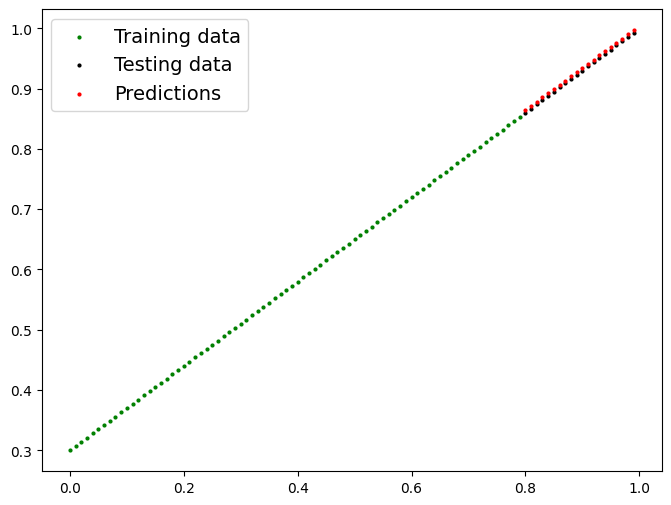

In [354]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

# 7. Saving and loading a model

In [355]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("/home/xia_1818/Naim/MyModel/models_20")


# 2. Create model save path 
MODEL_NAME = "module_02_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: /home/xia_1818/Naim/MyModel/models_20/module_02_workflow_model_1.pth


In [356]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


/tmp/ipykernel_1321890/2631515358.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


In [357]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

# Exercises


### Create a straight line dataset using the linear regression formula (weight * X + bias).
### Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
### Split the data into 80% training, 20% testing.
### Plot the training and testing data so it becomes visual.

In [370]:
# Create a dataset
weight = 0.3
bias = 0.9

start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1)

y = weight * X + bias

len(X), len(y),  X[:10], y[:10]

(100,
 100,
 tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.9000],
         [0.9030],
         [0.9060],
         [0.9090],
         [0.9120],
         [0.9150],
         [0.9180],
         [0.9210],
         [0.9240],
         [0.9270]]))

In [371]:
# Split the data into train and testing
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)


(80, 80, 20, 20)

In [382]:
# Plot the training and testing data so it becomes visal
def plot_predictionss(train_data=X_train,
                      train_labels= y_train,
                      test_data=X_test,
                      test_labels=y_test,
                      predictions=None):
    
    plt.figure(figsize=(8, 6))
    # Plot training data
    plt.scatter(train_data, train_labels, c='y', s=5, label='Training Data') # plot trian data in yellow
    plt.scatter(test_data, test_labels, c='g', s=5, label='Testing Data') # plot test data in green

    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=5, label="predictions")

    # show the legend
    plt.legend(props={'size' : 12})    

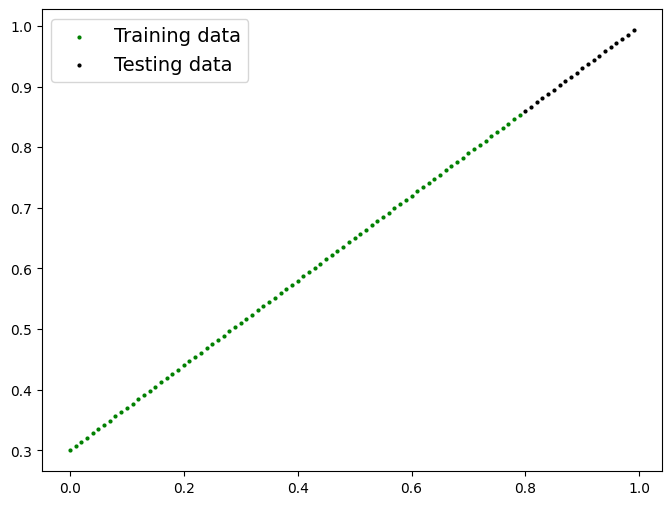

In [383]:
plot_predictions()

In [374]:
# make code agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [375]:
# Build a model
class LinearRegressionModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1
                                      )
        
    def forward(self, x: torch.Tensor)->torch.Tensor:
        return self.linear_layer(x) 

torch.manual_seed(42)
model_2 = LinearRegressionModelV3()
model_2, model_2.state_dict()
        

(LinearRegressionModelV3(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [376]:
# Model send to the GPU
model_2.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [377]:
# Create a loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [378]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 300

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 20 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 40 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 60 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 80 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 100 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 120 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 140 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 160 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 180 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 200 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 220 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch: 240 | Train loss: 0.43531280755996704 | Test loss: 0.2376178503036499
Epoch

In [379]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6954]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3085], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.3, bias: 0.9


In [402]:
# Making prediction
model_2.eval()

with torch.inference_mode():
    y_predic = model_2(X_test)

y_predic

tensor([[1.4416],
        [1.4493],
        [1.4569],
        [1.4646],
        [1.4722],
        [1.4799],
        [1.4875],
        [1.4952],
        [1.5028],
        [1.5104],
        [1.5181],
        [1.5257],
        [1.5334],
        [1.5410],
        [1.5487],
        [1.5563],
        [1.5640],
        [1.5716],
        [1.5793],
        [1.5869]], device='cuda:0')